In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [2]:
data_dir = "/kaggle/input/brain-tumor-classification-mri"
img_size = (224, 224)
batch_size = 32

### Data prep

In [3]:
def prepare_data(train_dir, test_dir, img_size, batch_size):
    train_datagen = ImageDataGenerator(rescale=1.0/255)
    test_datagen = ImageDataGenerator(rescale=1.0/255)

    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True
    )

    test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )

    return train_gen, test_gen

In [4]:
train_dir = os.path.join(data_dir, "Training")
test_dir = os.path.join(data_dir, "Testing")
train_gen, test_gen = prepare_data(train_dir, test_dir, img_size, batch_size)
num_classes = len(train_gen.class_indices)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [5]:
train_gen

In [6]:
print(f"Number of classes: {len(train_gen.class_indices)}")
print(f"Class labels: {train_gen.class_indices}")

Number of classes: 4
Class labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


# Data Encoding

In [7]:
def visualize_encoding(image_path, encoding_type='rate', time_window=100, max_spikes=20):
    # Select encoding function based on encoding_type
    if encoding_type == 'rate':
        encode_function = encode_rate_coding
    elif encoding_type == 'temporal':
        encode_function = encode_temporal_coding
    else:
        raise ValueError(f"Unsupported encoding type: {encoding_type}")
    
    # Get the spike train using the selected encoding method
    spike_train = encode_function(image_path, time_window, max_spikes)
    
    # Load the original image
    img = image.load_img(image_path, target_size=(128, 128), color_mode='grayscale')
    img_array = np.array(img) / 255.0
    
    # Create a figure to display the original and encoded images
    plt.figure(figsize=(10, 5))
    
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(img_array, cmap='gray')
    plt.title('Original MRI Image')
    
    # Encoded Image based on the encoding type
    plt.subplot(1, 2, 2)
    if encoding_type == 'rate':
        # For rate encoding, sum the spikes over time
        plt.imshow(np.sum(spike_train, axis=2), cmap='hot', interpolation='nearest')
        plt.title('Rate Coding Encoded Image')
    elif encoding_type == 'temporal':
        # For temporal encoding, display the first spike time
        plt.imshow(np.argmax(spike_train, axis=2), cmap='hot', interpolation='nearest')
        plt.title('Temporal Coding Encoded Image')
    
    plt.colorbar()
    plt.show()

In [8]:
def random_class_sample(train_gen, encoding_type='rate', num_samples=1, time_window=100, max_spikes=20):
    class_names = list(train_gen.class_indices.keys())
    
    for class_name in class_names:
        class_dir = os.path.join(train_dir, class_name)
        images = os.listdir(class_dir)
        
        # Randomly select a sample from each class
        random_image = random.choice(images)
        image_path = os.path.join(class_dir, random_image)
        
        print(f"Displaying sample from class: {class_name}")
        
        # Visualize original image and encoded spike train
        visualize_encoding(image_path, encoding_type, time_window, max_spikes)

### Rate encoding

* Concept: In rate coding, the information is encoded in the firing rate of the neurons. The more intense the input, the higher the rate of spikes within a fixed time window.

* Implementation: Convert the pixel values of the MRI images into spike trains by using the pixel intensity to determine the spike rate over a specific time window. The greater the pixel value, the more spikes are generated.

In [9]:
def encode_rate_coding(image_path, time_window=100, max_spikes=20):
    # Load image
    img = image.load_img(image_path, target_size=(128, 128), color_mode='grayscale')
    img_array = np.array(img) / 255.0  # Normalize the image

    # Initialize spike train
    spike_train = np.zeros((img_array.shape[0], img_array.shape[1], time_window))

    # Map pixel intensities to spike rates (higher intensity = more spikes)
    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            num_spikes = int(img_array[i, j] * max_spikes)  # Number of spikes is proportional to intensity
            spike_train[i, j, :num_spikes] = 1  # Set the spike train for the pixel

    return spike_train

Displaying sample from class: glioma_tumor


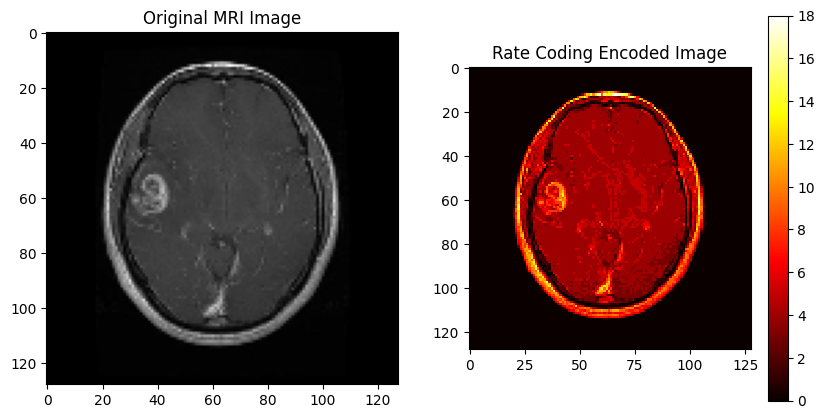

Displaying sample from class: meningioma_tumor


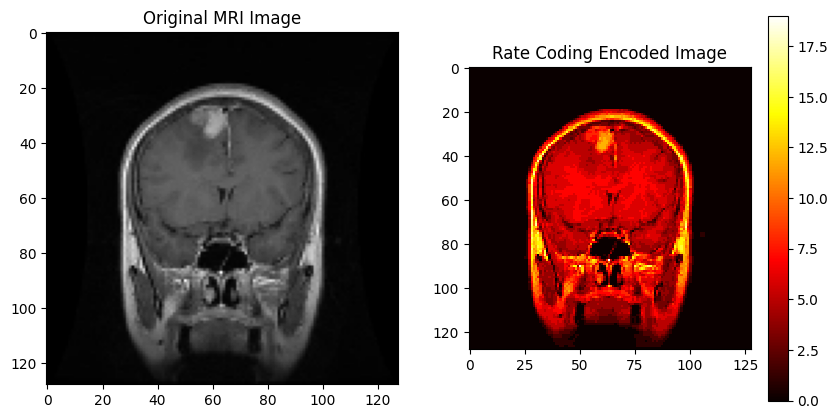

Displaying sample from class: no_tumor


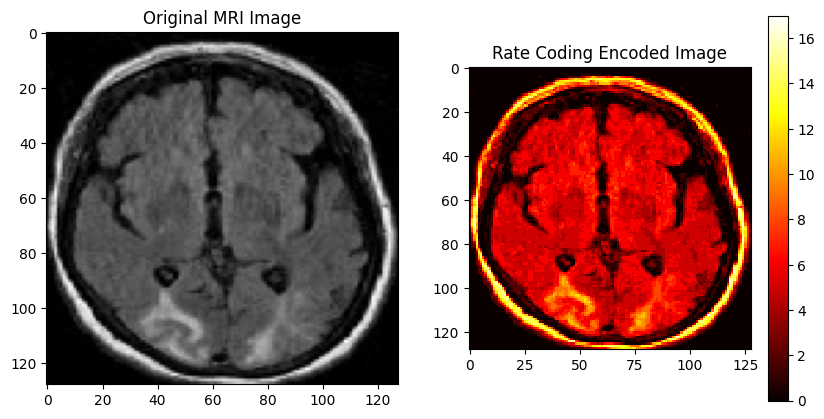

Displaying sample from class: pituitary_tumor


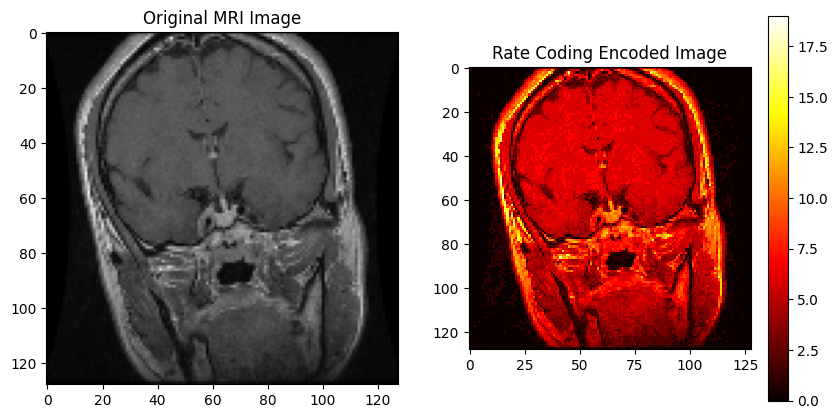

In [10]:
random_class_sample(train_gen, encoding_type='rate', num_samples=1)

In [11]:
# for potential reshaping to 4d inout
'''batch_size = all_spike_trains_array.shape[0]
height = all_spike_trains_array.shape[1]
width = all_spike_trains_array.shape[2]
time_steps = all_spike_trains_array.shape[3]

reshaped_data = all_spike_trains_array.reshape(batch_size, height, width, time_steps)'''

'batch_size = all_spike_trains_array.shape[0]\nheight = all_spike_trains_array.shape[1]\nwidth = all_spike_trains_array.shape[2]\ntime_steps = all_spike_trains_array.shape[3]\n\nreshaped_data = all_spike_trains_array.reshape(batch_size, height, width, time_steps)'

In [12]:
# https://www.mdpi.com/2076-3425/12/7/863

### Temporal Coding

* Concept: Temporal coding uses the precise timing of spikes to encode information. For example, an image might be represented by the timing of the first spike in response to each pixel or group of pixels.

* How to implement: Map pixel values to the timing of the first spike. The first spike for higher intensity pixels occurs sooner than for lower intensity pixels.

In [13]:
def encode_temporal_coding(image_path, time_window=100, max_spikes=20):
    # Load image
    img = image.load_img(image_path, target_size=(128, 128), color_mode='grayscale')
    img_array = np.array(img) / 255.0  # Normalize the image
    
    # Initialize spike train
    spike_train = np.zeros((img_array.shape[0], img_array.shape[1], time_window))
    
    # Map pixel intensities to spike times (higher intensity = earlier spike)
    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            num_spikes = int(img_array[i, j] * max_spikes)  # Number of spikes is proportional to intensity
            
            if num_spikes > 0:
                # Randomly distribute the spike times across the time window
                spike_times = np.random.choice(time_window, num_spikes, replace=False)
                spike_train[i, j, spike_times] = 1  # Set spikes at the randomly chosen time points
    
    return spike_train

Displaying sample from class: glioma_tumor


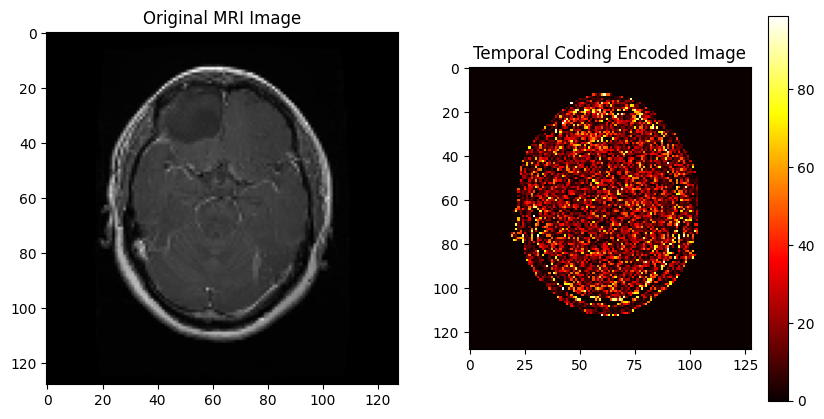

Displaying sample from class: meningioma_tumor


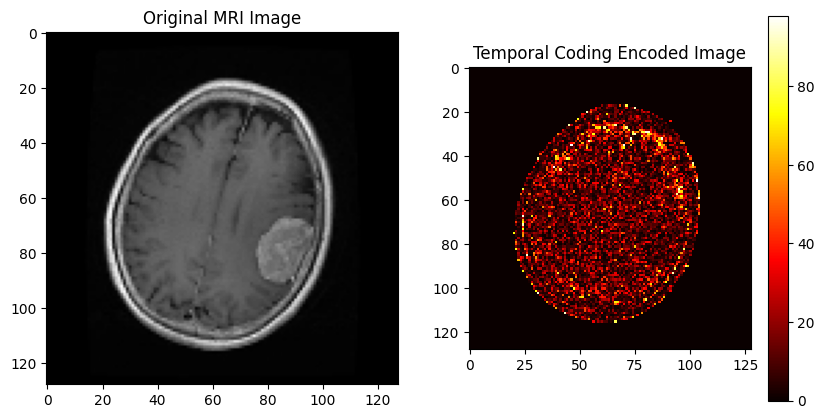

Displaying sample from class: no_tumor


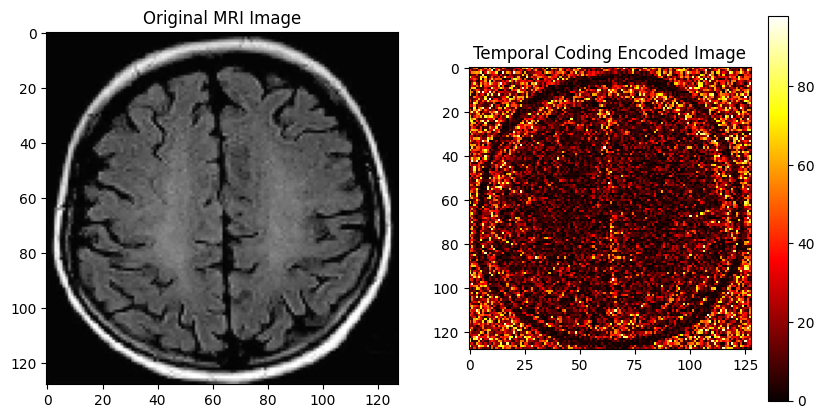

Displaying sample from class: pituitary_tumor


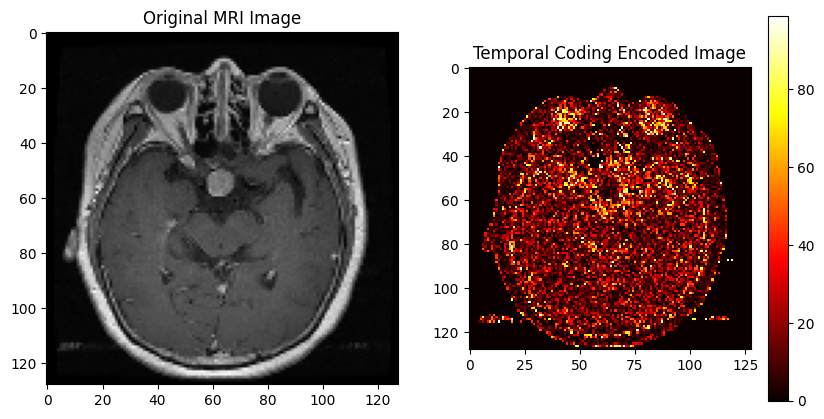

In [14]:
random_class_sample(train_gen, encoding_type='temporal', num_samples=1)

In [15]:
# https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9416238

In [16]:
'''def encode_image(directory, encoding_type='rate', time_window=100, max_spikes=20):
    encoded_images = {}
    
    if encoding_type == 'rate':
        encode_function = encode_rate_coding
    elif encoding_type == 'temporal':
        encode_function = encode_temporal_coding
    else:
        raise ValueError(f"Unsupported encoding type: {encoding_type}")
    
    # Initialize an empty list to hold the spike trains for all images
    all_spike_trains = []
    
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        
        if os.path.isdir(class_dir):
            encoded_images[class_name] = []
            
            # Iterate over all images in the class directory
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                
                # Encode the image using the selected encoding function
                spike_train = encode_function(image_path, time_window, max_spikes)
                
                # Append the spike train to the list for this class
                encoded_images[class_name].append(spike_train)
                
                # Append the spike train to the overall list
                all_spike_trains.append(spike_train)
    
    # Convert all_spike_trains to a numpy array (if needed)
    all_spike_trains_array = np.array(all_spike_trains)  # Shape: [num_images, height, width, time_steps]
    
    return encoded_images, all_spike_trains_array'''

'def encode_image(directory, encoding_type=\'rate\', time_window=100, max_spikes=20):\n    encoded_images = {}\n    \n    if encoding_type == \'rate\':\n        encode_function = encode_rate_coding\n    elif encoding_type == \'temporal\':\n        encode_function = encode_temporal_coding\n    else:\n        raise ValueError(f"Unsupported encoding type: {encoding_type}")\n    \n    # Initialize an empty list to hold the spike trains for all images\n    all_spike_trains = []\n    \n    for class_name in os.listdir(directory):\n        class_dir = os.path.join(directory, class_name)\n        \n        if os.path.isdir(class_dir):\n            encoded_images[class_name] = []\n            \n            # Iterate over all images in the class directory\n            for image_name in os.listdir(class_dir):\n                image_path = os.path.join(class_dir, image_name)\n                \n                # Encode the image using the selected encoding function\n                spike_train = en

### Encode all the images

#### Rate encoding

In [17]:
def process_directory_with_encoding(input_dir, output_dir, encoding_function, time_window=100, max_spikes=20):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through class directories
    for class_dir in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_dir)
        
        if os.path.isdir(class_path):
            # Create a subdirectory for each class in the output directory
            class_output_dir = os.path.join(output_dir, class_dir)
            if not os.path.exists(class_output_dir):
                os.makedirs(class_output_dir)
            
            # Iterate through all image files in the class directory
            for img_filename in os.listdir(class_path):
                img_path = os.path.join(class_path, img_filename)
                
                if img_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    print(f"Processing {img_filename} in class {class_dir}...")
                    
                    # Apply the selected encoding function
                    encoded_spike_train = encoding_function(img_path, time_window=time_window, max_spikes=max_spikes)
                    
                    # Determine output filename based on the encoding function
                    encoding_type = "rate" if encoding_function.__name__ == "encode_rate_coding" else "temporal"
                    output_filename = f"{os.path.splitext(img_filename)[0]}_{encoding_type}_encoded.npy"
                    output_path = os.path.join(class_output_dir, output_filename)
                    
                    # Save the encoded spike train
                    np.save(output_path, encoded_spike_train)
                    print(f"Saved {encoding_type}-encoded spike train for {img_filename} to {output_path}")

In [18]:
input_dir = "/kaggle/input/brain-tumor-classification-mri/Training"
output_dir = "/kaggle/working/Training_RateEnc"
process_directory_with_encoding(input_dir, output_dir, encode_rate_coding, time_window=100, max_spikes=20)
#process_directory_with_encoding(input_dir, output_dir, encode_temporal_coding, time_window=100, max_spikes=20)


Processing image(84).jpg in class no_tumor...


OSError: 1638400 requested and 1638384 written

# SNN Models

### Leaky Integrate and Fire (LIF)

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.cluster import KMeans

In [ ]:
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class LIFNeuron:
    def __init__(self, threshold=1.0, decay=0.9):
        self.threshold = threshold
        self.decay = decay
        self.potential = 0.0

    def process(self, inputs):
        """
        Process the input spike train and return the neuron's response.
        Inputs: Rate-encoded data (array).
        """
        spikes = []
        for t in inputs:
            self.potential += t  # Integrate input
            if self.potential >= self.threshold:  # Fire if threshold is reached
                spikes.append(1)
                self.potential = 0  # Reset potential after firing
            else:
                spikes.append(0)
            self.potential *= self.decay  # Apply decay
        return np.sum(spikes)  # Output the total number of spikes

# Load Encoded Data
def load_encoded_data(data_dir):
    data = []
    labels = []
    class_names = sorted(os.listdir(data_dir))  # Folder names as class labels
    class_to_index = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith('.npy'):
                file_path = os.path.join(class_dir, file_name)
                try:
                    encoded_data = np.load(file_path)
                    if encoded_data.size != 128 * 128 * 100:
                        print(f"Skipping {file_path} due to size mismatch")
                        continue
                    encoded_data = encoded_data.reshape(128, 128, 100)
                    data.append(encoded_data)
                    labels.append(class_to_index[class_name])
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue

    return np.array(data), np.array(labels), class_names

# Analyze Data with K-Means
def analyze_with_kmeans(data, labels, class_names, n_clusters=3):
    lif_neuron = LIFNeuron(threshold=1.0, decay=0.9)
    
    # Process each sample with the LIF neuron
    lif_outputs = []
    for sample in data:
        # Flatten the 3D array into 1D for processing
        lif_output = lif_neuron.process(sample.flatten())
        lif_outputs.append(lif_output)
    lif_outputs = np.array(lif_outputs)

    # K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    predicted_clusters = kmeans.fit_predict(lif_outputs.reshape(-1, 1))

    # Evaluate clustering performance
    print("Clustering Performance:")
    print(classification_report(labels, predicted_clusters, target_names=class_names))
    
    cm = confusion_matrix(labels, predicted_clusters)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap='Blues')
    plt.title("Confusion Matrix (Clustering)")
    plt.show()

    # Visualize clustering results
    plt.scatter(range(len(lif_outputs)), lif_outputs, c=predicted_clusters, cmap='viridis', label="Clusters")
    plt.title("K-Means Clustering of LIF Outputs")
    plt.xlabel("Sample Index")
    plt.ylabel("Spike Count")
    plt.colorbar(label="Cluster")
    plt.show()

# Main
data_dir = "/kaggle/working/Training_RateEnc"  # Replace with the path to your .npy files
data, labels, class_names = load_encoded_data(data_dir)
analyze_with_kmeans(data, labels, class_names, n_clusters=3)

Error loading /kaggle/working/Training_RateEnc/meningioma_tumor/m3 (105)_rate_encoded.npy: cannot reshape array of size 118256 into shape (128,128,100)
Error loading /kaggle/working/Training_RateEnc/no_tumor/image(84)_rate_encoded.npy: cannot reshape array of size 1638384 into shape (128,128,100)


In [ ]:
file_path = "/kaggle/working/Training_RateEnc/meningioma_tumor/m3 (105)_rate_encoded.npy"
data = np.load(file_path)
print(f"File Shape: {data.shape}, Size: {data.size}")
print(f"Data Sample: {data[:10]}")  # Print a small portion of the data


In [ ]:
def load_encoded_data(data_dir):
    """
    Load .npy files from subdirectories and associate them with their labels.
    """
    data = []
    labels = []
    class_names = sorted(os.listdir(data_dir))  # Folder names as class labels
    class_to_index = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith('.npy'):
                file_path = os.path.join(class_dir, file_name)
                encoded_data = np.load(file_path)
                print(f"Loaded file: {file_name}, Shape: {encoded_data.shape}")
                data.append(encoded_data)
                labels.append(class_to_index[class_name])

    return np.array(data), np.array(labels), class_names

print(load_encoded_data('/kaggle/working/Training_RateEnc'))

* Concept: The LIF model is a simple spiking neuron model where the membrane potential integrates incoming spikes and leaks over time. When the potential exceeds a threshold, the neuron fires.

* How to implement: Create a simple LIF neuron that takes input spikes and integrates them over time. This is one of the most commonly used models for SNNs.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow import keras

In [ ]:
# https://lcnwww.epfl.ch/gerstner/PUBLICATIONS/SpikingNeuronM-extracts.pdf

### Izhikevich Model

* Concept: The Izhikevich model is a more flexible and biologically plausible spiking neuron model. It can replicate various types of spiking behavior, such as regular spiking, bursting, and more.

* How to implement: Implement the Izhikevich neuron equations and adjust the parameters to simulate different firing patterns based on the encoded input.

In [ ]:
# https://www.nengo.ai/nengo/examples/advanced/izhikevich.html#:~:text=The%20Izhikevich%20neuron%20model%20is,model%20is%20implemented%20in%20Nengo.

### Hodgkin-Huxley Model

* Concept: The HH model is a detailed and biophysically realistic model that simulates the action potentials of neurons. It includes voltage-gated ion channels for a more accurate representation of neuronal behavior.

* How to implement: Implement the HH equations and simulate the response of neurons to spikes, with parameters such as sodium and potassium ion channel dynamics.

In [ ]:
# https://pmc.ncbi.nlm.nih.gov/articles/PMC1392413/